The prediction $\hat{r}_{u i}$ is set as:
$$
\hat{r}_{u i}=\mu+b_u+b_i+q_i^T p_u
$$

for biased version

To estimate all the unknown, we minimize the following regularized squared error:
$$
\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^2+\lambda\left(b_i^2+b_u^2+\left\|q_i\right\|^2+\left\|p_u\right\|^2\right)
$$

The minimization is performed by a very straightforward stochastic gradient descent:
$$
\begin{aligned}
b_u & \leftarrow b_u \quad+\gamma\left(e_{u i}-\lambda b_u\right) \\
b_i & \leftarrow b_i \quad+\gamma\left(e_{u i}-\lambda b_i\right) \\
p_u & \leftarrow p_u+\gamma\left(e_{u i} \cdot q_i-\lambda p_u\right) \\
q_i & \leftarrow q_i+\gamma\left(e_{u i} \cdot p_u-\lambda q_i\right)
\end{aligned}
$$
where $e_{u i}=r_{u i}-\hat{r}_{u i}$. 

For unbiased version we have
$$
\hat{r}_{u i}=q_i^T p_u
$$

In [1]:
import pickle
import pandas as pd
import numpy as np
import fastparquet
import surprise
from surprise.reader import Reader
from surprise.dataset import DatasetAutoFolds
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV
from surprise.accuracy import fcp, mae, mse, rmse
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly

In [2]:
with open("encode_decode/user_encode.pkl", "rb") as f:
    user_encode = pickle.load(f)
with open("encode_decode/user_decode.pkl", "rb") as f:
    user_decode = pickle.load(f)

with open("encode_decode/anime_encode.pkl", "rb") as f:
    anime_encode = pickle.load(f)
with open("encode_decode/anime_decode.pkl", "rb") as f:
    anime_decode = pickle.load(f)

df_train = pd.read_parquet("valid_train.parquet", engine="fastparquet")
df_test = pd.read_parquet("valid_test.parquet", engine="fastparquet")
reader = Reader(rating_scale=(1, 10))
data_train = DatasetAutoFolds(
    reader=reader,
    df=df_train[["user_id", "anime_id", "score"]],
).build_full_trainset()
data_test = (
    DatasetAutoFolds(
        reader=reader,
        df=df_test[["user_id", "anime_id", "score"]],
    )
    .build_full_trainset()
    .build_testset()
)
_raw_data_train = DatasetAutoFolds(
    reader=reader, df=df_train[["user_id", "anime_id", "score"]]
)

In [3]:
int_mat = pd.read_parquet("interactions.parquet", engine="fastparquet")
int_mat.fillna(0, inplace=True)
int_mat

,0,1,2,3,4,5,6,7,8,9,...,639,640,641,642,643,644,645,646,647,648
0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,0.0,0.0,0.0,7.0,7.0,0.0,6.0
4,7.0,7.0,8.0,0.0,7.0,8.0,8.0,6.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468,0.0,9.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,0.0,0.0,8.0,0.0,0.0
7469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,7.0
7470,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7471,0.0,0.0,8.0,0.0,6.0,0.0,0.0,9.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Performing SVD to find top-k dominant columns

In [4]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

svd = TruncatedSVD(n_components=int_mat.shape[1] - 1, n_iter=40)
svd.fit(int_mat.values)

TruncatedSVD(n_components=648, n_iter=40)

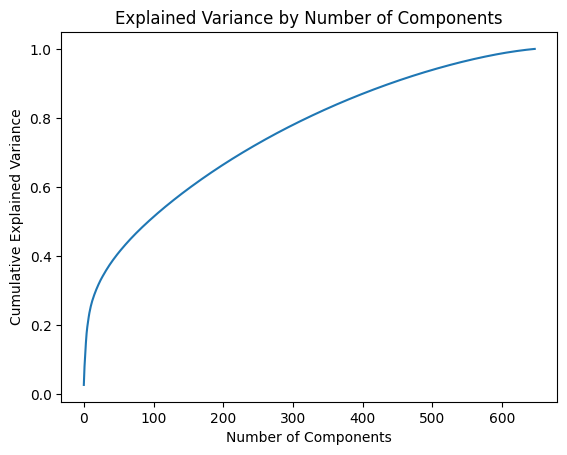

In [5]:
explained_variance = svd.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

plt.plot(cumulative_explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Number of Components")
plt.show()

In [6]:
cev = cumulative_explained_variance
e90 = sum(~(cev > 0.90))
e70 = sum(~(cev > 0.70))

In [7]:
random_model = NormalPredictor()
random_model.fit(data_train)
random_results = random_model.test(data_test)
print(f" FCP: {fcp(random_results,verbose=False)}")
print(f" MAE: {mae(random_results,verbose=False)}")
print(f" MSE: {mse(random_results,verbose=False)}")
print(f"RMSE: {rmse(random_results,verbose=False)}")

 FCP: 0.49887212676802717
 MAE: 1.8935139254519666
 MSE: 5.72375584666297
RMSE: 2.3924372189595635


## Simple BaseLine estimates using Alternate Least Square

In [8]:
param_bsl_als = {
    "bsl_options": {
        "method": ["als"],
        "reg_u": [0.1, 1, 3, 5],
        "reg_i": [0.1, 1, 3, 5],
        "n_epochs": [100],
    }
}

gs = GridSearchCV(
    BaselineOnly,
    param_bsl_als,
    measures=["mse", "mae"],
    cv=5,
    refit=True,
    n_jobs=-1,
    joblib_verbose=5,
)

In [ ]:
gs.fit(_raw_data_train)

In [10]:
df = pd.DataFrame(gs.cv_results)
df.to_json("./results/Baseline_ALS_gridCV.json")
df_final = df[
    [
        "mean_test_mae",
        "std_test_mae",
        "mean_test_mse",
        "std_test_mse",
        "params",
        "param_bsl_options",
    ]
]
df_final.sort_values("mean_test_mse", ascending=True).head(10)

,mean_test_mae,std_test_mae,mean_test_mse,std_test_mse,params,param_bsl_options
0,0.928661,0.001921,1.545419,0.005635,"{'bsl_options': {'method': 'als', 'reg_u': 0.1...","{'method': 'als', 'reg_u': 0.1, 'reg_i': 0.1, ..."
1,0.928656,0.001921,1.545424,0.005638,"{'bsl_options': {'method': 'als', 'reg_u': 0.1...","{'method': 'als', 'reg_u': 0.1, 'reg_i': 1, 'n..."
2,0.928645,0.001922,1.545439,0.005645,"{'bsl_options': {'method': 'als', 'reg_u': 0.1...","{'method': 'als', 'reg_u': 0.1, 'reg_i': 3, 'n..."
3,0.928635,0.001923,1.545457,0.005652,"{'bsl_options': {'method': 'als', 'reg_u': 0.1...","{'method': 'als', 'reg_u': 0.1, 'reg_i': 5, 'n..."
4,0.928773,0.001919,1.545475,0.005624,"{'bsl_options': {'method': 'als', 'reg_u': 1, ...","{'method': 'als', 'reg_u': 1, 'reg_i': 0.1, 'n..."
5,0.928769,0.001919,1.545481,0.005627,"{'bsl_options': {'method': 'als', 'reg_u': 1, ...","{'method': 'als', 'reg_u': 1, 'reg_i': 1, 'n_e..."
6,0.928758,0.001920,1.545496,0.005634,"{'bsl_options': {'method': 'als', 'reg_u': 1, ...","{'method': 'als', 'reg_u': 1, 'reg_i': 3, 'n_e..."
7,0.928748,0.001921,1.545514,0.005642,"{'bsl_options': {'method': 'als', 'reg_u': 1, ...","{'method': 'als', 'reg_u': 1, 'reg_i': 5, 'n_e..."
8,0.929134,0.001917,1.545964,0.005604,"{'bsl_options': {'method': 'als', 'reg_u': 3, ...","{'method': 'als', 'reg_u': 3, 'reg_i': 0.1, 'n..."
9,0.929130,0.001917,1.545971,0.005607,"{'bsl_options': {'method': 'als', 'reg_u': 3, ...","{'method': 'als', 'reg_u': 3, 'reg_i': 1, 'n_e..."


In [11]:
gs.best_params, gs.best_score

({'mse': {'bsl_options': {'method': 'als',
    'reg_u': 0.1,
    'reg_i': 0.1,
    'n_epochs': 100}},
  'mae': {'bsl_options': {'method': 'als',
    'reg_u': 0.1,
    'reg_i': 5,
    'n_epochs': 100}}},
 {'mse': 1.54541851580261, 'mae': 0.9286348068686909})

In [12]:
#! Optimmized for MSE

gs_r = gs.test(data_test)
print(f" FCP: {fcp(gs_r,verbose=False)}")
print(f" MAE: {mae(gs_r,verbose=False)}")
print(f" MSE: {mse(gs_r,verbose=False)}")
print(f"RMSE: {rmse(gs_r,verbose=False)}")

 FCP: 0.7151174659191107
 MAE: 0.9248180821730672
 MSE: 1.530374988423054
RMSE: 1.237083258484672


## Simple BaseLine estimates Stochastic Gradient Descent

In [13]:
param_bsl_sgd = {
    "bsl_options": {
        "method": ["sgd"],
        "reg_u": [0.01, 0.1, 1, 3, 5],
        "reg_i": [0.01, 0.1, 1, 3, 5],
        "n_epochs": [100],
    }
}

gs = GridSearchCV(
    BaselineOnly,
    param_bsl_sgd,
    measures=["mse", "mae"],
    cv=5,
    refit=True,
    n_jobs=-1,
    joblib_verbose=5,
)

In [ ]:
gs.fit(_raw_data_train)

In [15]:
df = pd.DataFrame(gs.cv_results)
df.to_json("./results/Baseline_SGD_gridCV.json")
df_final = df[
    [
        "mean_test_mae",
        "std_test_mae",
        "mean_test_mse",
        "std_test_mse",
        "params",
        "param_bsl_options",
    ]
]
df_final.sort_values("mean_test_mse", ascending=True).head(10)

,mean_test_mae,std_test_mae,mean_test_mse,std_test_mse,params,param_bsl_options
0,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 0.0...","{'method': 'sgd', 'reg_u': 0.01, 'reg_i': 0.01..."
22,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 5, ...","{'method': 'sgd', 'reg_u': 5, 'reg_i': 1, 'n_e..."
21,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 5, ...","{'method': 'sgd', 'reg_u': 5, 'reg_i': 0.1, 'n..."
20,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 5, ...","{'method': 'sgd', 'reg_u': 5, 'reg_i': 0.01, '..."
19,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 3, ...","{'method': 'sgd', 'reg_u': 3, 'reg_i': 5, 'n_e..."
18,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 3, ...","{'method': 'sgd', 'reg_u': 3, 'reg_i': 3, 'n_e..."
17,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 3, ...","{'method': 'sgd', 'reg_u': 3, 'reg_i': 1, 'n_e..."
16,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 3, ...","{'method': 'sgd', 'reg_u': 3, 'reg_i': 0.1, 'n..."
15,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 3, ...","{'method': 'sgd', 'reg_u': 3, 'reg_i': 0.01, '..."
14,0.929967,0.002032,1.548977,0.005295,"{'bsl_options': {'method': 'sgd', 'reg_u': 1, ...","{'method': 'sgd', 'reg_u': 1, 'reg_i': 5, 'n_e..."


In [16]:
gs.best_params, gs.best_score

({'mse': {'bsl_options': {'method': 'sgd',
    'reg_u': 0.01,
    'reg_i': 0.01,
    'n_epochs': 100}},
  'mae': {'bsl_options': {'method': 'sgd',
    'reg_u': 0.01,
    'reg_i': 0.01,
    'n_epochs': 100}}},
 {'mse': 1.5489769370887745, 'mae': 0.9299671961948001})

In [17]:
#! Optimmized for MSE

gs_r = gs.test(data_test)
print(f" FCP: {fcp(gs_r,verbose=False)}")
print(f" MAE: {mae(gs_r,verbose=False)}")
print(f" MSE: {mse(gs_r,verbose=False)}")
print(f"RMSE: {rmse(gs_r,verbose=False)}")

 FCP: 0.7143504495629619
 MAE: 0.9257741040380185
 MSE: 1.533710640469339
RMSE: 1.2384307168628121


## Matrix Factorization Method using SVD (biased)

In [18]:
param_grid = {
    "n_factors": [int_mat.shape[1] - 1, e90, e70, 100],
    "biased": [True],
    "lr_all": [0.001, 0.005, 0.01, 0.015],
    "reg_all": [0.005, 0.01, 0.05, 0.1],
    "n_epochs": [50],
}

gs = GridSearchCV(
    SVD,
    param_grid,
    measures=["mae", "mse"],
    cv=5,
    refit=True,
    n_jobs=-1,
    joblib_verbose=5,
)

In [19]:
gs.fit(_raw_data_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 31.2min finished


In [20]:
pd.DataFrame(gs.cv_results)

,split0_test_mae,split1_test_mae,split2_test_mae,split3_test_mae,split4_test_mae,mean_test_mae,std_test_mae,rank_test_mae,split0_test_mse,split1_test_mse,...,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_factors,param_biased,param_lr_all,param_reg_all,param_n_epochs
0,0.939668,0.940830,0.942453,0.943929,0.939898,0.941356,0.001617,52,1.551176,1.554119,...,169.642784,4.748457,4.851838,0.103523,"{'n_factors': 648, 'biased': True, 'lr_all': 0...",648,True,0.001,0.005,50
1,0.916226,0.917955,0.918477,0.918952,0.916965,0.917715,0.000995,48,1.482951,1.493058,...,187.488780,3.909040,4.932228,0.166082,"{'n_factors': 648, 'biased': True, 'lr_all': 0...",648,True,0.001,0.010,50
2,0.868854,0.869629,0.869163,0.872142,0.869510,0.869860,0.001173,25,1.356550,1.361942,...,190.943384,1.506068,4.778496,0.245536,"{'n_factors': 648, 'biased': True, 'lr_all': 0...",648,True,0.001,0.050,50
3,0.886489,0.887533,0.887244,0.890646,0.885980,0.887579,0.001629,34,1.408393,1.416974,...,188.246651,2.359161,4.870133,0.130765,"{'n_factors': 648, 'biased': True, 'lr_all': 0...",648,True,0.001,0.100,50
4,0.920010,0.922953,0.923839,0.923580,0.920643,0.922205,0.001573,49,1.497272,1.505484,...,189.479809,1.575499,5.242406,0.372453,"{'n_factors': 648, 'biased': True, 'lr_all': 0...",648,True,0.005,0.005,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.853373,0.853992,0.853857,0.856586,0.853011,0.854164,0.001261,14,1.311322,1.316530,...,16.785231,0.268097,2.457368,0.124694,"{'n_factors': 100, 'biased': True, 'lr_all': 0...",100,True,0.010,0.100,50
60,1.191060,1.191610,1.189999,1.192642,1.194977,1.192058,0.001691,64,2.532006,2.534028,...,16.667680,0.359298,2.396327,0.065382,"{'n_factors': 100, 'biased': True, 'lr_all': 0...",100,True,0.015,0.005,50
61,1.105502,1.105991,1.106010,1.108309,1.105743,1.106311,0.001016,62,2.186740,2.193865,...,16.488701,0.311361,1.949851,0.335539,"{'n_factors': 100, 'biased': True, 'lr_all': 0...",100,True,0.015,0.010,50
62,0.881637,0.882631,0.881158,0.884785,0.881620,0.882366,0.001301,31,1.406773,1.414417,...,15.067090,1.229358,1.637017,0.289823,"{'n_factors': 100, 'biased': True, 'lr_all': 0...",100,True,0.015,0.050,50


In [21]:
df = pd.DataFrame(gs.cv_results)
df.to_json("./results/SVD_Biased_gridCV.json")
df_final = df[
    [
        "mean_test_mae",
        "std_test_mae",
        "mean_test_mse",
        "std_test_mse",
        "params",
    ]
]
df_final.sort_values("mean_test_mse", ascending=True).head(10)

,mean_test_mae,std_test_mae,mean_test_mse,std_test_mse,params
6,0.847533,0.001152,1.304880,0.004271,"{'n_factors': 648, 'biased': True, 'lr_all': 0..."
22,0.848285,0.001136,1.307913,0.004093,"{'n_factors': 440, 'biased': True, 'lr_all': 0..."
23,0.852338,0.001342,1.312206,0.004632,"{'n_factors': 440, 'biased': True, 'lr_all': 0..."
7,0.852290,0.001310,1.312283,0.004546,"{'n_factors': 648, 'biased': True, 'lr_all': 0..."
39,0.852719,0.001382,1.313347,0.004948,"{'n_factors': 228, 'biased': True, 'lr_all': 0..."
10,0.850516,0.001280,1.313928,0.004576,"{'n_factors': 648, 'biased': True, 'lr_all': 0..."
55,0.853959,0.001355,1.316741,0.004675,"{'n_factors': 100, 'biased': True, 'lr_all': 0..."
43,0.853952,0.001346,1.316950,0.004603,"{'n_factors': 228, 'biased': True, 'lr_all': 0..."
27,0.853960,0.001307,1.317058,0.004503,"{'n_factors': 440, 'biased': True, 'lr_all': 0..."
11,0.853979,0.001351,1.317170,0.004513,"{'n_factors': 648, 'biased': True, 'lr_all': 0..."


In [22]:
gs.best_params, gs.best_score

({'mae': {'n_factors': 648,
   'biased': True,
   'lr_all': 0.005,
   'reg_all': 0.05,
   'n_epochs': 50},
  'mse': {'n_factors': 648,
   'biased': True,
   'lr_all': 0.005,
   'reg_all': 0.05,
   'n_epochs': 50}},
 {'mae': 0.8475328726345861, 'mse': 1.3048798956364338})

In [23]:
#! Optimmized for MSE

gs_r = gs.test(data_test)
print(f" FCP: {fcp(gs_r,verbose=False)}")
print(f" MAE: {mae(gs_r,verbose=False)}")
print(f" MSE: {mse(gs_r,verbose=False)}")
print(f"RMSE: {rmse(gs_r,verbose=False)}")

 FCP: 0.7623742969441965
 MAE: 0.8304404994296194
 MSE: 1.2569908704457067
RMSE: 1.1211560419699422


## Matrix Factorization Method using SVD (unbiased)

In [25]:

param_grid = {
    "n_factors": [int_mat.shape[1]-1, e90, e70, 100],
    "biased": [False],
    "lr_all": [0.001, 0.005, 0.01, 0.015],
    "reg_all": [0.005, 0.01, 0.05, 0.1],
    "n_epochs": [50]
}

gs = GridSearchCV(
    SVD,
    param_grid,
    measures=["mae", "mse"],
    cv=5,
    refit=True,
    n_jobs=-1,
    joblib_verbose=5,
)


In [26]:
gs.fit(_raw_data_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 31.6min finished


In [27]:
df = pd.DataFrame(gs.cv_results)
df.to_json("./results/SVD_NBiased_gridCV.json")
df_final = df[
    [
        "mean_test_mae",
        "std_test_mae",
        "mean_test_mse",
        "std_test_mse",
        "params",
    ]
]
df_final.sort_values("mean_test_mse", ascending=True).head(10)

,mean_test_mae,std_test_mae,mean_test_mse,std_test_mse,params
6,0.853168,0.001344,1.309087,0.004553,"{'n_factors': 648, 'biased': False, 'lr_all': ..."
22,0.854720,0.001498,1.313894,0.004488,"{'n_factors': 440, 'biased': False, 'lr_all': ..."
7,0.863045,0.001371,1.327905,0.004603,"{'n_factors': 648, 'biased': False, 'lr_all': ..."
23,0.863128,0.001474,1.328333,0.004877,"{'n_factors': 440, 'biased': False, 'lr_all': ..."
39,0.863720,0.001325,1.330283,0.004475,"{'n_factors': 228, 'biased': False, 'lr_all': ..."
38,0.859956,0.001151,1.330738,0.003362,"{'n_factors': 228, 'biased': False, 'lr_all': ..."
55,0.865141,0.001408,1.334612,0.004698,"{'n_factors': 100, 'biased': False, 'lr_all': ..."
10,0.863773,0.001497,1.336401,0.004269,"{'n_factors': 648, 'biased': False, 'lr_all': ..."
26,0.865579,0.001298,1.342243,0.003602,"{'n_factors': 440, 'biased': False, 'lr_all': ..."
2,0.867186,0.001241,1.344997,0.004275,"{'n_factors': 648, 'biased': False, 'lr_all': ..."


In [28]:
gs.best_params, gs.best_score

({'mae': {'n_factors': 648,
   'biased': False,
   'lr_all': 0.005,
   'reg_all': 0.05,
   'n_epochs': 50},
  'mse': {'n_factors': 648,
   'biased': False,
   'lr_all': 0.005,
   'reg_all': 0.05,
   'n_epochs': 50}},
 {'mae': 0.8531680528876568, 'mse': 1.3090868685962724})

In [29]:
#! Optimmized for MSE

gs_r = gs.test(data_test)
print(f" FCP: {fcp(gs_r,verbose=False)}")
print(f" MAE: {mae(gs_r,verbose=False)}")
print(f" MSE: {mse(gs_r,verbose=False)}")
print(f"RMSE: {rmse(gs_r,verbose=False)}")

 FCP: 0.7623290442804436
 MAE: 0.8356211971686291
 MSE: 1.2580559290943234
RMSE: 1.1216309237419961
